Test Accuracy: 78.78 %


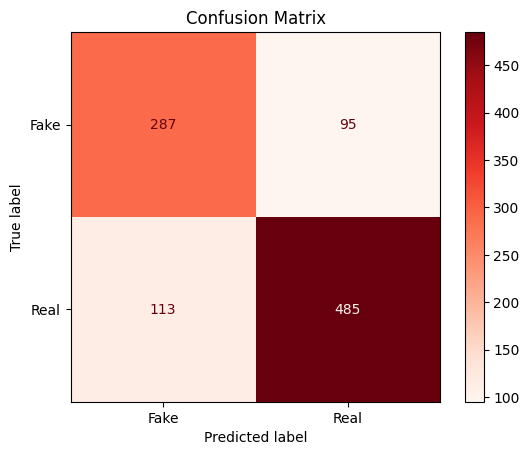

In [2]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# (a) Load data and extract features
def load_data(real_path, fake_path):
    with open(real_path, 'r') as f:
        real = [line.strip() for line in f if line.strip()]
    with open(fake_path, 'r') as f:
        fake = [line.strip() for line in f if line.strip()]
    
    headlines = real + fake
    labels = [1]*len(real) + [0]*len(fake)

    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(headlines)
    y = np.array(labels)
    return X, y, vectorizer

# (b) Filter features by document frequency
def filter_features(X, vectorizer, min_df=0.005, max_df=0.7):
    doc_freq = np.asarray((X > 0).sum(axis=0)).flatten()
    total_docs = X.shape[0]
    mask = (doc_freq >= min_df * total_docs) & (doc_freq <= max_df * total_docs)

    selected_indices = np.where(mask)[0]
    selected_features = [word for idx, word in enumerate(vectorizer.get_feature_names_out()) if idx in selected_indices]
    
    new_vectorizer = CountVectorizer(vocabulary=selected_features)
    # Convert back to strings from bag-of-words
    documents = [" ".join(doc) for doc in vectorizer.inverse_transform(X)]
    X_new = new_vectorizer.fit_transform(documents)
    return X_new, new_vectorizer

# (c) Naive Bayes classifier
def Naive_Bayes(X_train, X_test, y_train, y_test):
    alpha = 1

    fake_idx = np.where(y_train == 0)[0]
    real_idx = np.where(y_train == 1)[0]

    prior_fake = len(fake_idx) / len(y_train)
    prior_real = len(real_idx) / len(y_train)

    word_count_fake = X_train[fake_idx].sum(axis=0) + alpha
    word_count_real = X_train[real_idx].sum(axis=0) + alpha

    word_count_fake = np.asarray(word_count_fake).flatten()
    word_count_real = np.asarray(word_count_real).flatten()

    total_words_fake = word_count_fake.sum()
    total_words_real = word_count_real.sum()

    prob_w_given_fake = word_count_fake / total_words_fake
    prob_w_given_real = word_count_real / total_words_real

    log_prob_fake = np.log(prob_w_given_fake)
    log_prob_real = np.log(prob_w_given_real)

    log_prior_fake = np.log(prior_fake)
    log_prior_real = np.log(prior_real)

    y_pred = []
    for i in range(X_test.shape[0]):
        x = X_test[i].toarray().flatten()
        log_likelihood_fake = log_prior_fake + np.sum(x * log_prob_fake)
        log_likelihood_real = log_prior_real + np.sum(x * log_prob_real)
        y_pred.append(1 if log_likelihood_real > log_likelihood_fake else 0)

    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    print(f"Test Accuracy: {acc * 100:.2f} %")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
    disp.plot(cmap='Reds')
    plt.title("Confusion Matrix")
    plt.show()
    return acc, cm

# MAIN
def main():
    real_path = 'NaiveBayesData/real.txt'
    fake_path = 'NaiveBayesData/fake.txt'
    
    X, y, vectorizer = load_data(real_path, fake_path)
    X_filtered, filtered_vectorizer = filter_features(X, vectorizer)

    X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.3, random_state=42)

    Naive_Bayes(X_train, X_test, y_train, y_test)

if __name__ == "__main__":
    main()
